# Simulation and Monte Carlo Methods : Unbiased Gradient

Ce projet reproduit les premières expériences numériques du papier ["On Multilevel Monte Carlo Unbiased Gradient Estimation
For Deep Latent Variable Models"](http://proceedings.mlr.press/v130/shi21d.html) écrit par Shi et Cornish (2021). Le but est d'estimer la log-vraisemblance et de son gradient, par différents estimateurs. Nous nous plaçons dans le cas linéaire Gaussien étudié dans ["Tighter Variational Bounds are Not Necessarily Better"](https://arxiv.org/pdf/1802.04537) publié par Rainforth et al. (2018).

Nous estimons d'abord la log-vraisemblance, puis le gradient pour chaque estimateur. Nous étudions ensuite les biais et variances des estimateurs. Enfin, nous regardons le résultat d'une descente de gradient stochastique pour chacun des estimateurs.


## I. Estimation de la vraisemblance

Commençons par importer les bibliothèques nécessaires.

In [2]:
import numpy as np
from scipy.stats import norm, multivariate_normal, geom
import matplotlib.pyplot as plt

Fixons les paramètres du modèle.

In [3]:
N_sample = 128
dim_x = 20
dim_z = 20
r = 0.6

def logmeanexp(data):
    max_val = np.max(data)
    return max_val + np.log(np.mean(np.exp(data - max_val)))

On tire ici le paramètre du modèle &theta;<sub>0</sub> (selon une loi normale centrée réduite), puis on génère nos données X, qui suit la loi $$ p_{\theta_{0}}(x) = \mathcal{N}(x|\theta_{0}, 2I) $$

In [4]:
def p_theta_x(theta):
    mu = theta
    covariance = 2 * np.eye(dim_x)
    return multivariate_normal(mean=mu, cov=covariance)

In [5]:
theta_0 = norm.rvs(loc=0, scale=1)
print('theta_0 =', theta_0)
X = p_theta_x(np.zeros(dim_x) + theta_0).rvs()
print('X =', X)
print('moyenne X =', np.mean(X))

theta_0 = 0.03975976023419071
X = [-1.24527829 -0.29999651 -2.36817753  1.07985011 -1.96239812  0.35095157
  1.33080257  0.74213743 -0.16862579  1.63910914 -1.59352927  1.41800466
 -0.66101087  1.54611626 -1.92620329 -1.77688166 -0.09958516  0.04602573
 -3.3269592  -0.7694374 ]
moyenne X = -0.4022542808836894


```latex
On implante la distribution de l'encodeur $$ q_{\phi}(z|x) = \mathcal{N}(z| Ax+b, \frac{2}{3}I) $$, où A et b sont les paramètres optimaux pour ce problème.

In [6]:
def q_phi_z_given_x(X):
    A = 1 / 2 * np.eye(dim_z, dim_x) #size = dim_z, dim_x
    b = np.zeros(dim_z) + np.mean(X) #size = dim_z, 1
    mu = A @ X + b
    mu = X
    covariance = 2 / 3 * np.eye(dim_z)
    return multivariate_normal(mean=mu, cov=covariance)

def generation_Z(X, size):
    Z = q_phi_z_given_x(X).rvs(size=size)
    Z_E, Z_O = Z[::2], Z[1::2]
    return Z, Z_E, Z_O

On définit maintenant les distributions $$ p_{\theta}(x|z) = \mathcal{N}(x|z, I) $$ et $$ p_{\theta}(z) = \mathcal{N}(z|\theta, I) $$, qui permettront de calculer les poids d'importance.

In [7]:
def p_theta_x_given_z(z):
    mu = z
    covariance = np.eye(dim_x)
    return multivariate_normal(mean=mu, cov=covariance)

def p_theta_z(theta):
    mu = np.zeros(dim_z) + theta
    covariance = np.eye(dim_z)
    return multivariate_normal(mean=mu, cov=covariance)

On implémente l'estimateur "multilevel single sample" à partir des équations $$ss = I_{0} + \frac{\Delta^{ML}_{K}}{p(K)} \text{  et}$$ $$\Delta^{ML}_{k}= \hat{l}^{(2^{k+1})}_{O\cup E}(\theta) - \frac{1}{2} \left( \hat{l}^{(2^{k})}_{O}(\theta) + \hat{l}^{(2^{k})}_{E}(\theta)\right) \text{  , où  } K∼Geom(r)$$

In [8]:
def estimateur_ml_ss(theta, X, N_sample):
    l_hat_ml_ss_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        log_weights_E, log_weights_O = log_weights[::2], log_weights[1::2]
        I_0 = np.mean(log_weights)
        l_hat_E, l_hat_O = logmeanexp(log_weights_E), logmeanexp(log_weights_O)
        l_hat_O_E = logmeanexp(log_weights)
        delta_K = l_hat_O_E - 0.5 * (l_hat_O + l_hat_E)
        l_hat_ml_ss_lst.append(I_0 + delta_K / geom(r).pmf(K))
    l_hat_ml_ss = np.mean(l_hat_ml_ss_lst)
    return l_hat_ml_ss

On implémente l'estimateur "multilevel russian roulette" à partir des équations $$rr = I_{0} + \sum^{K}_{k=0}\frac{\Delta^{ML}_{k}}{\mathbb{P}(K \geq k)} \text{  et}$$ $$\Delta^{ML}_{k}= \hat{l}^{(2^{k+1})}_{O\cup E}(\theta) - \frac{1}{2} \left( \hat{l}^{(2^{k})}_{O}(\theta) + \hat{l}^{(2^{k})}_{E}(\theta)\right) \text{, où  } K∼Geom(r)$$

In [9]:
def estimateur_ml_rr(theta, X, N_sample):
    l_hat_ml_rr_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        log_weights_E, log_weights_O = log_weights[::2], log_weights[1::2]
        I_0 = np.mean(log_weights)
        l_hat_E, l_hat_O = logmeanexp(log_weights_E), logmeanexp(log_weights_O)
        l_hat_O_E = logmeanexp(log_weights)
        delta_k_list_rr = [logmeanexp(log_weights[:2**(k+1)]) - 0.5 * (logmeanexp(log_weights_O[:2**k]) + logmeanexp(log_weights_E[:2**k])) for k in range(K+1)]
        l_hat_ml_rr_lst.append(I_0 + np.sum([delta_k_list_rr[k] / (1 - geom(r).cdf(k-1)) for k in range(K+1)]))
    l_hat_ml_rr = np.mean(l_hat_ml_rr_lst)
    return l_hat_ml_rr

On implémente l'estimateur "Importance Weighted Autoencoder" (IWAE).

In [10]:
def estimateur_iwae(theta, X, N_sample):
    l_hat_iwae_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        l_hat_iwae_lst.append(logmeanexp(log_weights))
    l_hat_iwae = np.mean(l_hat_iwae_lst)
    return l_hat_iwae

On implémente l'estimateur SUMO à partir des équations $$SUMO = I_{0} + \sum^{K}_{k=0}\frac{\Delta^{SUMO}_{k}}{\mathbb{P}(K \geq k)} \text{   et}$$ $$\Delta^{SUMO}_{k}= \hat{l}^{(2^{k+1})}(\theta) - \hat{l}^{(2^{k})}(\theta) \text{  , où   } K∼Geom(r)$$

In [11]:
def estimateur_sumo(theta, X, N_sample):
    l_hat_sumo_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        log_weights_E, log_weights_O = log_weights[::2], log_weights[1::2]
        I_0 = np.mean(log_weights)
        delta_k_list_sumo = [logmeanexp(log_weights[:2**(k+1)]) - logmeanexp(log_weights[:2**k]) for k in range(K+1)]
        l_hat_sumo_lst.append(I_0 + np.sum([delta_k_list_sumo[k] / (1 - geom(r).cdf(k-1)) for k in range(K+1)]))
    l_hat_sumo = np.mean(l_hat_sumo_lst)
    return l_hat_sumo

On calcule pour chaque estimateur, leur valeur pour différentes valeurs de $$\theta.$$

In [12]:
theta_lst = np.linspace(-3, 3, 50)

l_hat_ml_ss = [estimateur_ml_ss(theta, X, N_sample) for theta in theta_lst]
print('l_hat_ml_ss : ok')

l_hat_ml_rr = [estimateur_ml_rr(theta, X, N_sample) for theta in theta_lst]
print('l_hat_ml_rr : ok')

l_hat_iwae = [estimateur_iwae(theta, X, N_sample) for theta in theta_lst]
print('l_hat_iwae : ok')

l_hat_sumo = [estimateur_sumo(theta, X, N_sample) for theta in theta_lst]
print('l_hat_sumo : ok')

KeyboardInterrupt: 

On calcule la log-vraisemblance du modèle pour ces mêmes valeurs de $$\theta.$$

In [ ]:
def true_likelihood(X, theta):
    l_true = 1
    for x in X:
        l_true *= norm.pdf(x, loc=theta, scale=np.sqrt(2))
    return l_true


l_true = [np.log(true_likelihood(X, theta)) for theta in theta_lst]  

On trace les valeurs des estimateurs en fonction de $$\theta.$$

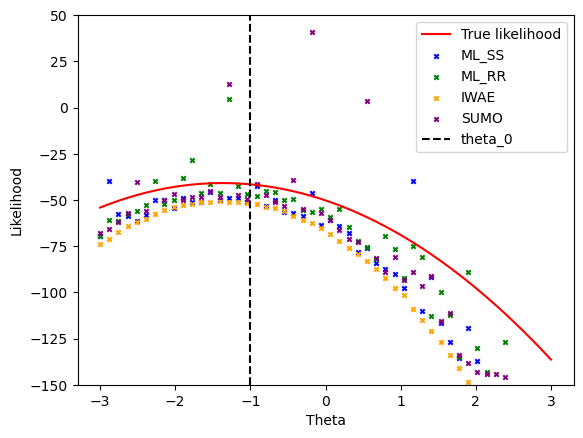

In [ ]:
plt.plot(theta_lst, l_true, color='red', label='True likelihood')
plt.scatter(theta_lst, l_hat_ml_ss, color='blue', marker='x', label='ML_SS', s=10)
plt.scatter(theta_lst, l_hat_ml_rr, color='green', marker='x', label='ML_RR', s=10)
plt.scatter(theta_lst, l_hat_iwae, color='orange', marker='x', label='IWAE', s=10)
plt.scatter(theta_lst, l_hat_sumo, color='purple', marker='x', label='SUMO', s=10)
plt.axvline(x=theta_0, color='black', linestyle='--', label='theta_0')
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.legend(loc='best')
plt.ylim(-150, 50)
plt.show()

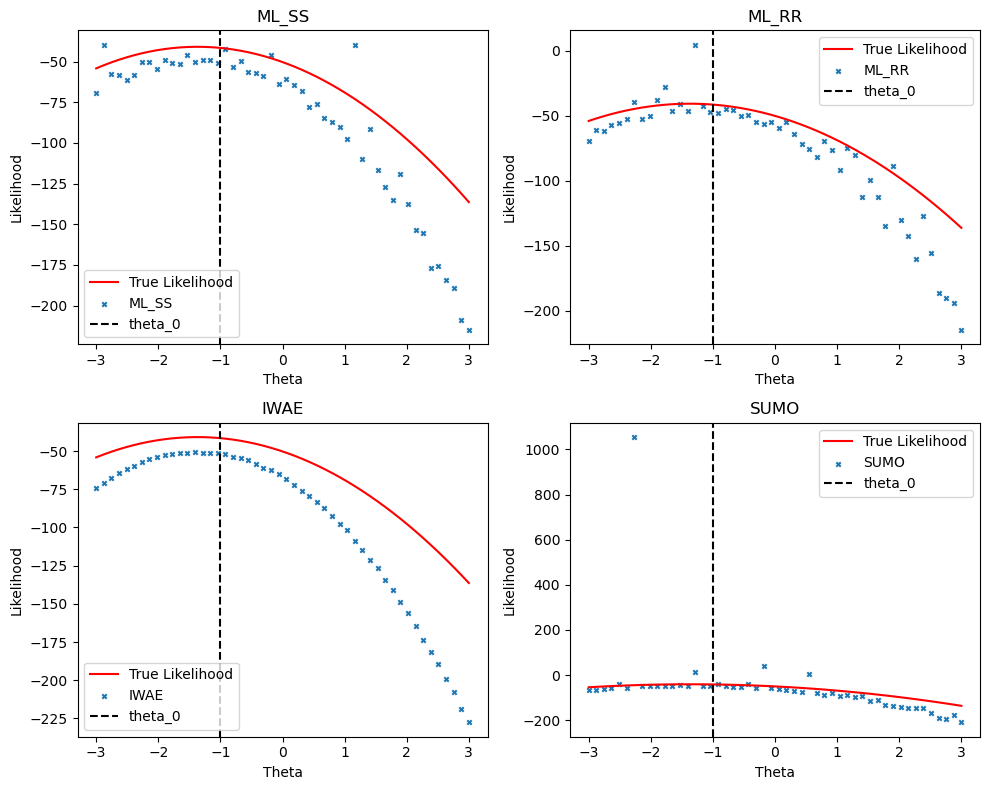

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

estimator_names = ['ML_SS', 'ML_RR', 'IWAE', 'SUMO']
estimators = [l_hat_ml_ss, l_hat_ml_rr, l_hat_iwae, l_hat_sumo]

for i, ax in enumerate(axs.flat):
    ax.plot(theta_lst, l_true, color='r', label='True Likelihood')
    ax.scatter(theta_lst, estimators[i], label=estimator_names[i], marker='x', s=10)
    ax.axvline(x=theta_0, color='black', linestyle='--', label='theta_0')
    ax.set_xlabel('Theta')
    ax.set_ylabel('Likelihood')
    ax.legend(loc='best')
    #ax.set_ylim(-200, 50)
    ax.set_title(estimator_names[i])

plt.tight_layout()
plt.show()

## II. Estimation du gradient

On calcule les gradients des estimateurs pour différentes valeurs de $$\theta.$$

In [ ]:
theta_lst_grad = theta_lst[::2]

l_grad_hat_ml_ss = np.gradient(l_hat_ml_ss[::2]) 
l_grad_hat_ml_rr = np.gradient(l_hat_ml_rr[::2])
l_grad_hat_iwae = np.gradient(l_hat_iwae[::2])
l_grad_hat_sumo = np.gradient(l_hat_sumo[::2])

On calcule le gradient du modèle pour ces mêmes valeurs de $$\theta.$$

In [ ]:
def true_gradient(X, theta):
    return  10 * (np.mean(X) - theta)

l_grad_true = [true_gradient(X, theta) for theta in theta_lst_grad]

On trace les gradients en fonction de $$\theta.$$

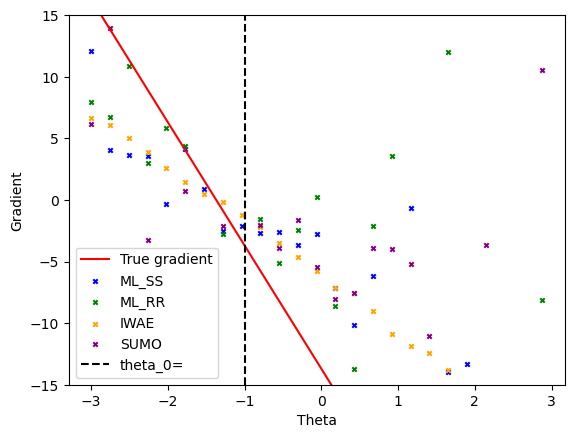

In [ ]:
plt.plot(theta_lst_grad, l_grad_true, color='r', label='True gradient')
plt.scatter(theta_lst_grad, l_grad_hat_ml_ss, color='blue', marker='x', label='ML_SS', s=10)
plt.scatter(theta_lst_grad, l_grad_hat_ml_rr, color='green', marker='x', label='ML_RR', s=10)
plt.scatter(theta_lst_grad, l_grad_hat_iwae, color='orange', marker='x', label='IWAE', s=10)
plt.scatter(theta_lst_grad, l_grad_hat_sumo, color='purple', marker='x', label='SUMO', s=10)
plt.axvline(x=theta_0, color='black', linestyle='--', label='theta_0=')
plt.xlabel('Theta')
plt.ylabel('Gradient')
plt.legend(loc='best')
plt.ylim(-15, 15)
plt.show()

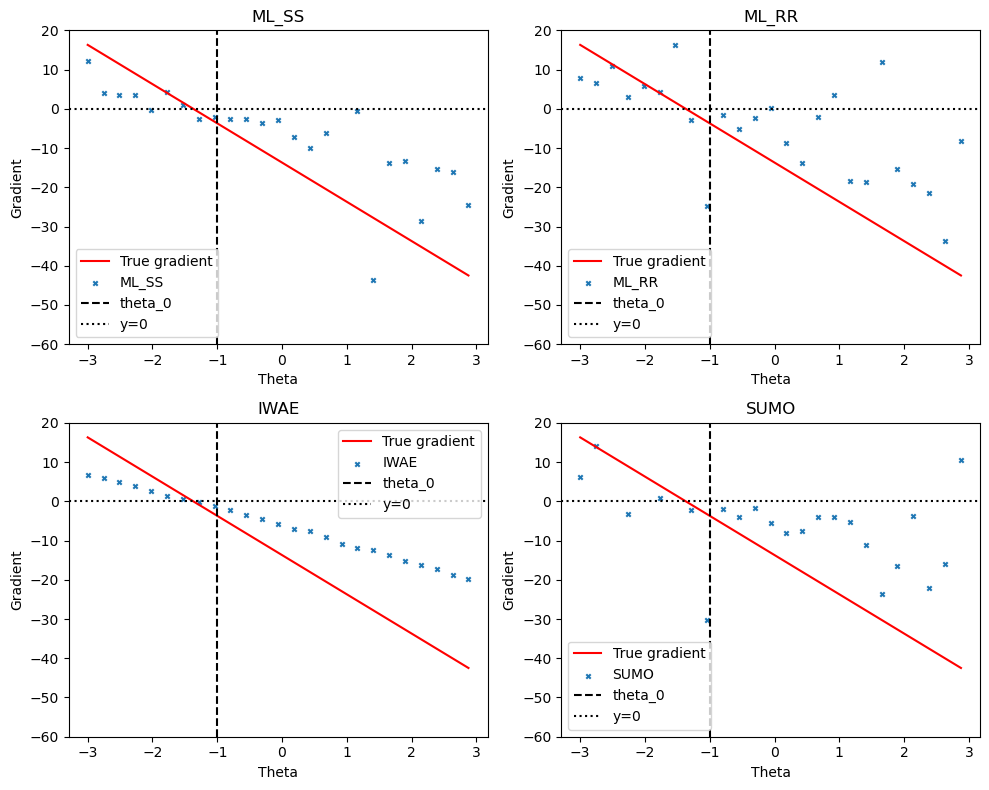

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

grad_estimators = [l_grad_hat_ml_ss, l_grad_hat_ml_rr, l_grad_hat_iwae, l_grad_hat_sumo]

for i, ax in enumerate(axs.flat):
    ax.plot(theta_lst_grad, l_grad_true, color='r', label='True gradient')
    ax.scatter(theta_lst_grad, grad_estimators[i], label=estimator_names[i], marker='x', s=10)
    ax.axvline(x=theta_0, color='black', linestyle='--', label='theta_0')
    ax.axhline(y=0, color='black', linestyle=':', label='y=0')
    ax.set_xlabel('Theta')
    ax.set_ylabel('Gradient')
    ax.set_title(estimator_names[i])
    ax.legend(loc='best')
    ax.set_ylim(-60, 20)

plt.tight_layout()
plt.show()


# III. Etude biais/variance

On définit une fonction qui renvoie un dictionnaire contenant le biais et la variance pour chaque méthode, pour un N_sample fixé.

In [ ]:
def biais_variance(N_sim):

    l_ss = [estimateur_ml_ss(theta, X, N_sim) for theta in theta_lst]
    l_rr = [estimateur_ml_rr(theta, X, N_sim) for theta in theta_lst]
    l_iwae = [estimateur_iwae(theta, X, N_sim) for theta in theta_lst]
    l_sumo = [estimateur_sumo(theta, X, N_sim) for theta in theta_lst]

    estimation_values = {'IWAE' : l_iwae,
                         'SS' : l_ss,
                         'RR' : l_rr,
                         'SUMO' : l_sumo
                         }       
    
    biais_variance_grad = {'IWAE' : {}, 'SS' : {}, 'RR' : {}, 'SUMO' : {}}
    biais_variance_esti = {'IWAE' : {}, 'SS' : {}, 'RR' : {}, 'SUMO' : {}}
    
    for method in biais_variance_grad.keys():
        esti_list = estimation_values[method]
        grad_list = np.gradient(esti_list[::2])
        mean_esti = np.mean(esti_list)
        mean_grad  = np.mean(grad_list)
        biais_variance_grad[method]['biais'] = np.mean(list(map(lambda x,y:(x-y)**2, grad_list, l_grad_true)))
        biais_variance_grad[method]['variance'] = np.std(grad_list)
        biais_variance_esti[method]['biais'] = np.mean(list(map(lambda x,y:(x-y)**2, esti_list, l_true)))
        biais_variance_esti[method]['variance'] = np.std(grad_list)
        
    return biais_variance_esti, biais_variance_grad

On calcule, pour une liste d'entiers représentant le nombre de similuation, le biais et la variance de chaque estimateur

In [ ]:
n_sim_list = np.arange(100, 500, 100)

biais_var_grad = {'IWAE' : {'biais' : [], 'variance' : []}, 
             'SS' : {'biais' : [], 'variance' : []}, 
             'RR' : {'biais' : [], 'variance' : []}, 
             'SUMO' : {'biais' : [], 'variance' : []}
             }

biais_var_esti = {'IWAE' : {'biais' : [], 'variance' : []}, 
             'SS' : {'biais' : [], 'variance' : []}, 
             'RR' : {'biais' : [], 'variance' : []}, 
             'SUMO' : {'biais' : [], 'variance' : []}
             }


for n_sim in n_sim_list : 
    biais_variance_esti, biais_variance_grad = biais_variance(n_sim)
    for method in biais_variance_esti.keys():
        biais_var_grad[method]['biais'].append(biais_variance_grad[method]['biais'])
        biais_var_grad[method]['variance'].append(biais_variance_grad[method]['variance'])
        biais_var_esti[method]['biais'].append(biais_variance_esti[method]['biais'])
        biais_var_esti[method]['variance'].append(biais_variance_esti[method]['variance'])

NameError: name 'np' is not defined

### Tracé des biais

In [ ]:
for method in biais_var.keys():
    plt.plot(n_sim_list, biais_var_esti[method]['biais'], label = method)

plt.xlabel('N_simulation')
plt.yscale('log')
plt.ylabel('Mean Biais Squared')
plt.title('Biais squared of the log_likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for method in biais_var.keys():
    plt.plot(n_sim_list, biais_var_grad[method]['biais'], label = method)

plt.xlabel('N_simulation')
plt.yscale('log')
plt.ylabel('Mean Biais Squared')
plt.title('Biais squared of the gradient')
plt.legend()
plt.grid(True)
plt.show()

### Tracé des variances

In [ ]:
for method in biais_var.keys():
    plt.plot(n_sim_list, biais_var_esti[method]['variance'], label = method)

plt.xlabel('N_simulation')
plt.ylabel('Standard error')
plt.title('Standard-error of the log-likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for method in biais_var.keys():
    plt.plot(n_sim_list, biais_var_grad[method]['variance'], label = method)

plt.xlabel('N_simulation')
plt.ylabel('Standard error')
plt.title('Standard-error of the gradient')
plt.legend()
plt.grid(True)
plt.show()

## IV. Stochastic Gradient Descent

On implémente une SGD pour chaque estimateur et pour le vrai modèle, et on regarde quelles valeurs de $$\hat\theta$$ nous obtenons.

In [ ]:
def cost_function_derivative(theta, theta_lst, l_grad_hat):
    return l_grad_hat[np.argmin(np.abs(theta_lst - theta))]

def sgd(theta_lst, l_grad_hat, learning_rate, N_iter):
    theta = 0
    for i in range(N_iter):
        gradient = cost_function_derivative(theta, theta_lst, l_grad_hat)
        theta += learning_rate * gradient
    return theta

In [ ]:
print('theta_0 = ', theta_0)
for i in range(4):
    l_grad_hat = grad_estimators[i]
    sgdi = sgd(theta_lst_grad, l_grad_hat, 0.001, 1000)
    print('Pour', estimator_names[i], ': theta =', sgdi)
print('Pour vrai sgd :', sgd(theta_lst_grad, l_grad_true, 0.001, 1000))

theta_0 =  -0.9994228601936174
Pour ML_SS : theta = -1.4092605371050873
Pour ML_RR : theta = 0.059813530225313986
Pour IWAE : theta = -1.2683994662878268
Pour SUMO : theta = -1.3921824462027266
Pour vrai sgd : -1.4083159052694805
